In [1]:
import nest
import nest.raster_plot
import numpy as np
from utils.inputs import generate_piecewise_constant_signal
import matplotlib.pyplot as plt
from scipy import sparse


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.7.0
 Built: Oct 17 2024 16:05:40

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In this example, we will compare the network dynamics in the noise- and input-driven regimes. For that purpose, we first drive the network with constant Poissonian input for a period of 1s, followed by patterned stimulation with an inhomogeneous Poisson generator for an additional 1s. 

# Global settings

In [2]:
seed = 1
np.random.seed(seed)

In [3]:
dt = 0.1  # simulation resolution
sim_time = 1000. # simulation time [ms] (for each epoch)

num_threads = 8

# Initialize NEST
nest.ResetKernel()
nest.SetKernelStatus({
    'rng_seed': seed,
    'resolution': dt,
    'print_time': True,
    'local_num_threads': num_threads})


Oct 20 22:52:56 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.


---
# Balanced Random Network

For this example, we will use a standard Brunel balanced random network (see NEST tutorials). However, you are encouraged to explore different neuron and synapse models.

In [4]:
# network parameters
gamma = 0.25               # relative number of inhibitory connections
NE = 1000                  # number of excitatory neurons (10.000 in [1])
NI = int(gamma * NE)       # number of inhibitory neurons
CE = 100                   # indegree from excitatory neurons
CI = int(gamma * CE)       # indegree from inhibitory neurons

In [5]:
def get_sparse_matrix(rows,cols,probability,seed):
    # Set the random seed for reproducibility
    rng = np.random.default_rng(seed)
    # Generate a random sparse matrix with values 0 or 1
    sparse_matrix = sparse.random(rows, cols, density=probability, format='csr', random_state=rng, data_rvs=lambda s: rng.integers(1, 2, size=s))
    # Convert the sparse matrix to a dense format
    dense_matrix = sparse_matrix.toarray()
    return dense_matrix

In [6]:
# synapse parameters
w = 0.1                    # excitatory synaptic weight (mV)
#w *= np.sqrt(10)
g = 5.                     # relative inhibitory to excitatory synaptic weight
d = 1.5                    # synaptic transmission delay (ms)

w = 0.1
n_clusters = 4
wc = [w *i for i in range(1,n_clusters+1)]
w_ex = np.full((NE,NE),w,dtype=np.float64)
nn_c = int(NE/n_clusters)# number of units per cluster
for i_n in range(n_clusters):
    st=i_n*nn_c
    end=(i_n+1)*nn_c
    w_ex[st:end,st:end] = wc[i_n]
wi = np.full((NI,NE),-w*g)
w_i = -w*g
w_sparse = get_sparse_matrix(rows=w_ex.shape[0],cols=w_ex.shape[1],probability=0.1,seed=seed)
w_sparse = w_ex*w_sparse

In [7]:
# neuron paramters
V_th = 20.                 # spike threshold (mV)
tau_m = 20.                # membrane time constant (ms)
neuron_params = {
    'C_m': 1.0,            # membrane capacity (pF)
    'E_L': 0.,             # resting membrane potential (mV)
    'I_e': 0.,             # external input current (pA)
    'V_m': 0.,             # membrane potential (mV)
    'V_reset': 10.,        # reset membrane potential after a spike (mV)
    'V_th': V_th,          #
    't_ref': 2.0,          # refractory period (ms)
    'tau_m': tau_m,        #
}

### Create and connect populations

In [8]:
# set default parameters for neurons and create neurons
nest.SetDefaults('iaf_psc_delta', neuron_params)
neurons_e = nest.Create('iaf_psc_delta', NE)
neurons_i = nest.Create('iaf_psc_delta', NI)

# # create excitatory connections
# # synapse specification
syn_exc = {'delay': d, 'weight': w}
# # connection specification
# conn_exc = {'rule': 'fixed_indegree', 'indegree': CE}
# # connect stuff
# nest.Connect(neurons_e, neurons_e, conn_exc, syn_exc)
# nest.Connect(neurons_e, neurons_i, conn_exc, syn_exc)

# # create inhibitory connections
# # synapse specification
syn_inh = {'delay': d, 'weight': - g * w}
# # connection specification
# conn_inh = {'rule': 'fixed_indegree', 'indegree': CI}
# # connect stuff
# nest.Connect(neurons_i, neurons_e, conn_inh, syn_inh)
# nest.Connect(neurons_i, neurons_i, conn_inh, syn_inh)

neurons = neurons_e + neurons_i
for i_row in range(NE):
    # select non-zero weights
    nonzero = w_sparse != 0
    nonzero_row = nonzero[i_row]

    nest.Connect(neurons_e[i_row], neurons_e[nonzero_row],
                conn_spec = {'rule': 'all_to_all'},
                syn_spec = {'synapse_model': 'static_synapse',
                            'delay': 1.5,
                            'weight': w_sparse[i_row][nonzero_row].reshape((-1,1))})

nest.Connect(neurons_e, neurons_i,
                conn_spec = {'rule': 'fixed_indegree',
                            'indegree': CE},
                syn_spec = {'synapse_model': 'static_synapse',
                            'delay': 1.5,
                            'weight': 0.1})


nest.Connect(neurons_i, neurons,
                conn_spec = {'rule': 'fixed_indegree',
                            'indegree': CI},
                syn_spec = {'synapse_model': 'static_synapse',
                            'delay': 1.5,
                            'weight': w_i})

### Create and connect external inputs
We are going to drive the circuit with noise for an initial period, followed by a patterned stimulus signal.

In [9]:
# external input parameters (background noise)
nu_th = V_th / (w * CE * tau_m) # external rate needed to evoke activity (spikes/ms)
nu_ex = 2.0 * nu_th             # set external rate above threshold
p_rate = 1e3 * nu_ex * CE       # external rate (spikes/s)

In [10]:
print(
    w, 
    nu_ex,
    nu_th,
    p_rate
)

0.1 0.2 0.1 20000.0


In [11]:
# external input (stimulus)
step_duration = 50.    # [ms]
scale = p_rate / 2.    # scale input amplitude (max. rate)

sig, times, inp_times, inp_amplitudes = generate_piecewise_constant_signal(seed=seed, num_steps=int(sim_time/step_duration), step_duration=step_duration, resolution=dt, scale=scale)
inp_times += sim_time  # stimulus starts after the noise phase

Text(0.5, 1.0, '$u(t)$')

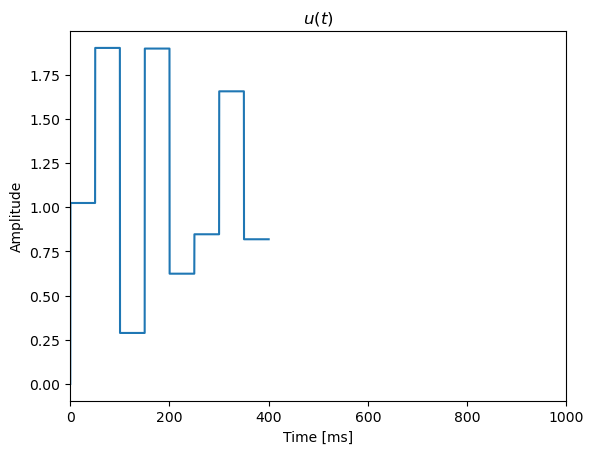

In [12]:
# visualize example input stimulus
fig, ax = plt.subplots()
ax.plot(times, sig)
ax.set_xlim([0, 1000])
ax.set_xlabel(r'Time [ms]')
ax.set_ylabel(r'Amplitude')
ax.set_title(r'$u(t)$')

In [13]:
# create poisson generator (noise phase)
noise_pgen = nest.Create('poisson_generator', params={'rate': p_rate, 'stop': sim_time})

# create inhomogeneous poisson generator (time-dependent input signal)
stim_pgen = nest.Create('inhomogeneous_poisson_generator', 1)
nest.SetStatus(stim_pgen, params={'rate_times': inp_times, 'rate_values': inp_amplitudes})

In [14]:
# connect poisson generator using the excitatory connection weight
nest.Connect(noise_pgen, neurons_i, syn_spec=syn_exc)
nest.Connect(noise_pgen, neurons_e, syn_spec=syn_exc)

nest.Connect(stim_pgen, neurons_e, syn_spec=syn_exc)
nest.Connect(stim_pgen, neurons_i, syn_spec=syn_exc)


### Create and connect recording devices
Since we are going to compare the population responses to stimulus versus noise, the simplest way is to record them separately. 

In [15]:
spikes_E_noise = nest.Create('spike_recorder')
spikes_E_noise.stop = sim_time
spikes_I_noise = nest.Create('spike_recorder')
spikes_I_noise.stop = sim_time
spikes_E_stim  = nest.Create('spike_recorder')
spikes_E_stim.start = sim_time
spikes_I_stim  = nest.Create('spike_recorder')
spikes_I_stim.start = sim_time

In [16]:
# connect neurons to spike detectors
nest.Connect(neurons_e, spikes_E_noise)
nest.Connect(neurons_e, spikes_E_stim)
nest.Connect(neurons_i, spikes_I_noise)
nest.Connect(neurons_i, spikes_I_stim)

## Simulate and analyse

In [17]:
# simulate (noise-driven phase)
nest.Simulate(sim_time) 

# calculate mean firing rate in spikes per second
events_ex = nest.GetStatus(spikes_E_noise, 'n_events')[0]
events_in = nest.GetStatus(spikes_I_noise, 'n_events')[0]
rate_ex = events_ex / sim_time / NE * 1e3
rate_in = events_in / sim_time / NI * 1e3
mean_rate = (rate_ex + rate_in) / 2.
print('Mean firing rate: {} Hz (E: {} Hz, I: {} Hz)'.format(mean_rate, rate_ex, rate_in))


Oct 20 22:52:59 NodeManager::prepare_nodes [Info]: 
    Preparing 1298 nodes for simulation.

Oct 20 22:52:59 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1298
    Simulation time (ms): 400
    Number of OpenMP threads: 8
    Not using MPI

[ 100% ] Model time: 400.0 ms, Real-time factor: 0.3635

Oct 20 22:52:59 SimulationManager::run [Info]: 
    Simulation finished.
Mean firing rate: 106.38125 Hz (E: 113.4825 Hz, I: 99.28 Hz)


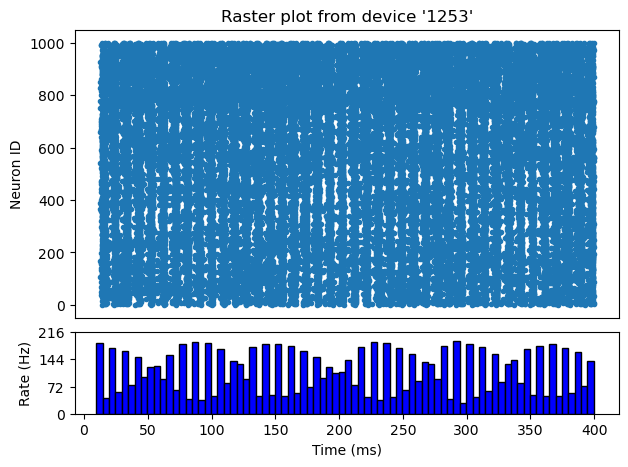

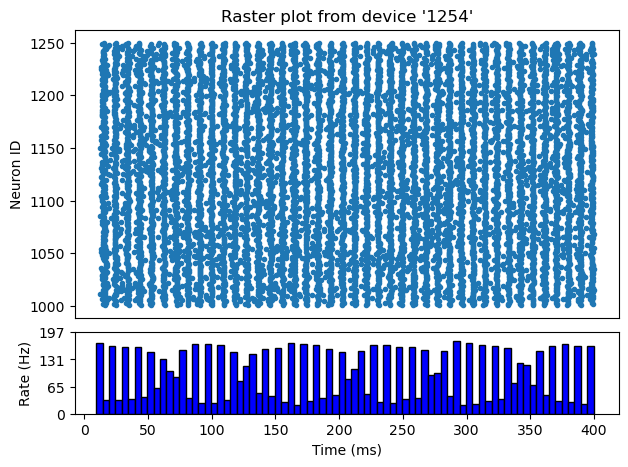

In [18]:
# raster plot of spiking activity using nest.raster_plot
nest.raster_plot.from_device(spikes_E_noise, hist=True)
nest.raster_plot.from_device(spikes_I_noise, hist=True)

In [19]:
# simulate (stimulus-driven phase)
nest.Simulate(sim_time) 

# calculate mean firing rate in spikes per second
events_ex = nest.GetStatus(spikes_E_stim, 'n_events')[0]
events_in = nest.GetStatus(spikes_I_stim, 'n_events')[0]
rate_ex = events_ex / sim_time / NE * 1e3
rate_in = events_in / sim_time / NI * 1e3
mean_rate = (rate_ex + rate_in) / 2.
print('Mean firing rate: {} Hz (E: {} Hz, I: {} Hz)'.format(mean_rate, rate_ex, rate_in))


Oct 20 22:53:00 NodeManager::prepare_nodes [Info]: 
    Preparing 1298 nodes for simulation.

Oct 20 22:53:00 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1298
    Simulation time (ms): 400
    Number of OpenMP threads: 8
    Not using MPI

[ 100% ] Model time: 800.0 ms, Real-time factor: 0.2382

Oct 20 22:53:00 SimulationManager::run [Info]: 
    Simulation finished.
Mean firing rate: 40.7 Hz (E: 44.7 Hz, I: 36.7 Hz)


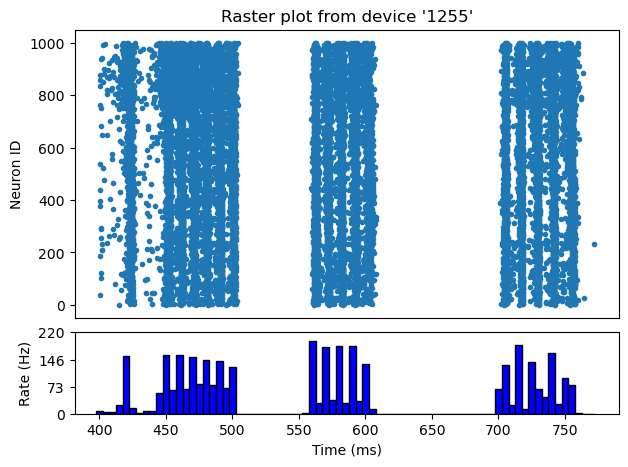

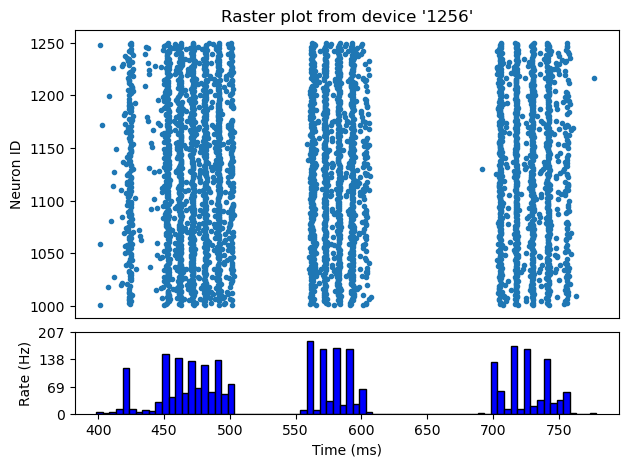

In [20]:
# raster plot of spiking activity using nest.raster_plot
nest.raster_plot.from_device(spikes_E_stim, hist=True)
nest.raster_plot.from_device(spikes_I_stim, hist=True)

To explore:

* Characterize the population activity statistics in the two regimes, evaluating the distribution of rates, regularity ($CV_{ISI}$) and synchrony (pairwise correlation coefficient) 
* Change the stimulation parameters to reach a *healthier* dynamic regime in the input-driven condition
* Test different neuron and synapse models